# How to implement Simulated Annealing in Python
Simulated Annealing is a stochastic global search optimization algorithm. This means that it makes use of randomness as part of the search process. This makes the algorithm appropriate for nonlinear objective functions where other local search algorithms do not operate well. 

Like the Stochastic Hill Climbing algorithm, it modifies a single solution and searches the relatively local area of the search space until the local optima is located. Unlike the Hill Climbing algorithms, it may accept a worse solution as the current working solution. The likelihood of accepting a worse solution starts high at the beginning of the search and decreases with the progress of the search, giving the algorithm the opportunity to first locate the region for the global optima, escaping local optima, then hill climb to the optima itself.

## Simulated Annealing
The algorithm is inspired by annealing in metallurgy where metal is heated to a high temperature quickly, then cooled slowly, which increases its strength and makes it easier to work with. The annealing process works by first exciting the atoms in the material at a high temperature, allowing the atoms to move around a lot, then decreasing their excitement slowly, allowing the atoms to fall into a new, more stable configuration. When hot, the atoms in the material are more free to move around, and, through random motion, tend to settle into better positions. A slow cooling brings the material to an ordered, crystalline state.

The Simulated Annealing algorithm can be thought of as a modified version of Stochastic Hill Climbing which maintains a single candidate solution and takes steps of a random but constrained size from the candidate in the search space. If the new point is better than the current point, then the current point is replaced with the new point. This process continues for a fixed number of iterations.

Simulated annealing executes the search in the same way. The main difference is that new points that are not as good as the current point (worse points) are accepted sometimes. A worse point is accepted probabilistically where the likelihood of accepting a solution worse than the current solution is a function of the temperature of the search and how much worse the solution is than the current solution.

The algorithm varies from Hill-Climbing in its decision of when to replace S, the original candidate solution, with R, its newly tweaked child. Specifically: if R is better than S, we’ll always replace S with R as usual. But if R is worse than S, we may still replace S with R with a certain probability

The initial temperature for the search is provided as a hyperparameter and decreases with the progress of the search. A number of different schemes (annealing schedules) may be used to decrease the temperature during the search from the initial value to a very low value, although it is common to calculate temperature as a function of the iteration number.

A popular example for calculating temperature is the so-called *fast simulated annealing* calculated as follows:

$temperature = \frac{temp_{initial}}{iter_{number} + 1}$

The acceptance of worse solutions uses the temperature as well as the difference between the objective function evaluation of the worse solution and the current solution. A value is calculated between 0 and 1 using this information, indicating the likelihood of accepting the worse solution. This distribution is then sampled using a random number, which, if less than the value, means the worse solution is accepted.

It is this acceptance probability, known as the Metropolis criterion, that allows the algorithm to escape from local minima when the temperature is high. This is called the metropolis acceptance criterion and for minimization is calculated as follows:

$criterion = exp( \frac{-(obj_{new} – obj_{curr})}{temp})$

Where $exp()$ is e (the mathematical constant) raised to a power of the provided argument, and $obj_{new}$, and $obj_{curr}$ are the objective function evaluation of the new (worse) and current candidate solutions.

The effect is that poor solutions have more chances of being accepted early in the search and less likely of being accepted later in the search. The intent is that the high temperature at the beginning of the search will help the search locate the basin for the global optima and the low temperature later in the search will help the algorithm hone in on the global optima.

The temperature starts high, allowing the process to freely move about the search space, with the hope that in this phase the process will find a good region with the best local minimum. The temperature is then slowly brought down, reducing the stochasticity and forcing the search to converge to a minimum

## Implementation

In [ ]:
# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
    # generate an initial point
    best = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = curr + randn(len(bounds)) * step_size
        # evaluate candidate point
        candidate_eval = objective(candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # report progress
            print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval]

Our initial point is a random point within the bounds of the problem which is then evaluated using the objective function. We need to maintain the *current* solution.  

The first step of the algorithm iteration is to generate a new candidate solution from the current working solution, e.g. take a step. This requires a predefined *step_size* parameter, which is relative to the bounds of the search space. We will take a random step with a Gaussian distribution where the mean is our current point and the standard deviation is defined by the *step_size*.

Next, we need to evaluate it. We then need to check if the evaluation of this new point is as good as or better than the current best point, and if it is, replace our current best point with this new point. Otherwise, we need to see if we should replace the current working solution. 

The first step is to calculate the difference between the objective function evaluation of the current solution and the current working solution. Next, we need to calculate the current temperature, using the fast annealing schedule, where *temp* is the initial temperature provided as an argument. We can then calculate the likelihood of accepting a solution with worse performance than our current working solution.

Finally, we can accept the new point as the current working solution if it has a better objective function evaluation (the difference is negative) or if the objective function is worse, but we probabilistically decide to accept it.

## Applying the Simulated Annealing Algorithm
First, let’s define our objective function. We will use a simple one-dimensional $x^2$ objective function with the bounds $[-5, 5]$.

The example below defines the function, then creates a line plot of the response surface of the function for a grid of input values, and marks the optima at f(0.0) = 0.0 with a red line

In [ ]:
# convex unimodal optimization function
from numpy import arange
from matplotlib import pyplot
 
# objective function
def objective(x):
    return x[0]**2.0
 
# define range for input
r_min, r_max = -5.0, 5.0
# sample input range uniformly at 0.1 increments
inputs = arange(r_min, r_max, 0.1)
# compute targets
results = [objective([x]) for x in inputs]
# create a line plot of input vs result
pyplot.plot(inputs, results)
# define optimal input value
x_optima = 0.0
# draw a vertical line at the optimal input
pyplot.axvline(x=x_optima, ls='--', color='red')
# show the plot
pyplot.show()

Before we apply the optimization algorithm to the problem, let’s take a moment to understand the acceptance criterion a little better.

First, the fast annealing schedule is an exponential function of the number of iterations. We can make this clear by creating a plot of the temperature for each algorithm iteration. We will use an initial temperature of 10 and 100 algorithm iterations, both arbitrarily chosen.

Running the example calculates the temperature for each algorithm iteration and creates a plot of algorithm iteration (x-axis) vs. temperature (y-axis).

We can see that temperature drops rapidly, exponentially, not linearly, such that after 20 iterations it is below 1 and stays low for the remainder of the search.

In [ ]:

# explore temperature vs algorithm iteration for simulated annealing
from matplotlib import pyplot
# total iterations of algorithm
iterations = 100
# initial temperature
initial_temp = 10
# array of iterations from 0 to iterations - 1
iterations = [i for i in range(iterations)]
# temperatures for each iterations
temperatures = [initial_temp/float(i + 1) for i in iterations]
# plot iterations vs temperatures
pyplot.plot(iterations, temperatures)
pyplot.xlabel('Iteration')
pyplot.ylabel('Temperature')
pyplot.show()

Next, we can get a better idea of how the metropolis acceptance criterion changes over time with the temperature.

Recall that the criterion is a function of temperature, but is also a function of how different the objective evaluation of the new point is compared to the current working solution. As such, we will plot the criterion for a few different “differences in objective function value” to see the effect it has on acceptance probability.

Running the example calculates the metropolis acceptance criterion for each algorithm iteration using the temperature shown for each iteration (shown in the previous section). The plot has three lines for three differences between the new worse solution and the current working solution.

We can see that the worse the solution is (the larger the difference), the less likely the model is to accept the worse solution regardless of the algorithm iteration, as we might expect. We can also see that in all cases, the likelihood of accepting worse solutions decreases with algorithm iteration.

In [ ]:

# explore metropolis acceptance criterion for simulated annealing
from math import exp
from matplotlib import pyplot
# total iterations of algorithm
iterations = 100
# initial temperature
initial_temp = 10
# array of iterations from 0 to iterations - 1
iterations = [i for i in range(iterations)]
# temperatures for each iterations
temperatures = [initial_temp/float(i + 1) for i in iterations]
# metropolis acceptance criterion
differences = [0.01, 0.1, 1.0]
for d in differences:
    metropolis = [exp(-d/t) for t in temperatures]
    # plot iterations vs metropolis
    label = 'diff=%.2f' % d
    pyplot.plot(iterations, metropolis, label=label)
# inalize plot
pyplot.xlabel('Iteration')
pyplot.ylabel('Metropolis Criterion')
pyplot.legend()
pyplot.show()

Now that we are more familiar with the behavior of the temperature and metropolis acceptance criterion over time, let’s apply simulated annealing to our test problem.

First, we will seed the pseudorandom number generator. Next, we can define the configuration of the search. In this case, we will search for 1,000 iterations of the algorithm and use a step size of 0.1. We will also use an initial temperature of 10.0. The search procedure is more sensitive to the annealing schedule than the initial temperature, as such, initial temperature values are almost arbitrary. Next, we can perform the search and report the results.

In [ ]:
# simulated annealing search of a one-dimensional objective function
from numpy import asarray
from numpy import exp
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
 
# objective function
def objective(x):
    return x[0]**2.0
 
# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
    # generate an initial point
    best = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = curr + randn(len(bounds)) * step_size
        # evaluate candidate point
        candidate_eval = objective(candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # report progress
            print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval]
 
# seed the pseudorandom number generator
seed(1)

# define range for input
bounds = asarray([[-5.0, 5.0]])

# define the total iterations
n_iterations = 1000

# define the maximum step size
step_size = 0.1

# initial temperature
temp = 10

# perform the simulated annealing search
best, score = simulated_annealing(objective, bounds, n_iterations, step_size, temp)
print('Done!')
print('f(%s) = %f' % (best, score))

Running the example reports the progress of the search including the iteration number, the input to the function, and the response from the objective function each time an improvement was detected. At the end of the search, the best solution is found and its evaluation is reported. In this case, we can see about 20 improvements over the 1,000 iterations of the algorithm and a solution that is very close to the optimal input of 0.0 that evaluates to f(0.0) = 0.0.

## Plotting progress
It can be interesting to review the progress of the search as a line plot that shows the change in the evaluation of the best solution each time there is an improvement. We can update the *simulated_annealing()* to keep track of the objective function evaluations each time there is an improvement and return this list of scores. We can then create a line plot of these scores to see the relative change in objective function for each improvement found during the search.

>34 f([-0.78753544]) = 0.62021
>35 f([-0.76914239]) = 0.59158
>37 f([-0.68574854]) = 0.47025
>39 f([-0.64797564]) = 0.41987
>40 f([-0.58914623]) = 0.34709
>41 f([-0.55446029]) = 0.30743
>42 f([-0.41775702]) = 0.17452
>43 f([-0.35038542]) = 0.12277
>50 f([-0.15799045]) = 0.02496
>66 f([-0.11089772]) = 0.01230
>67 f([-0.09238208]) = 0.00853
>72 f([-0.09145261]) = 0.00836
>75 f([-0.05129162]) = 0.00263
>93 f([-0.02854417]) = 0.00081
>144 f([0.00864136]) = 0.00007
>149 f([0.00753953]) = 0.00006
>167 f([-0.00640394]) = 0.00004
>225 f([-0.00044965]) = 0.00000
>503 f([-0.00036261]) = 0.00000
>512 f([0.00013605]) = 0.00000
Done!
f([0.00013605]) = 0.000000


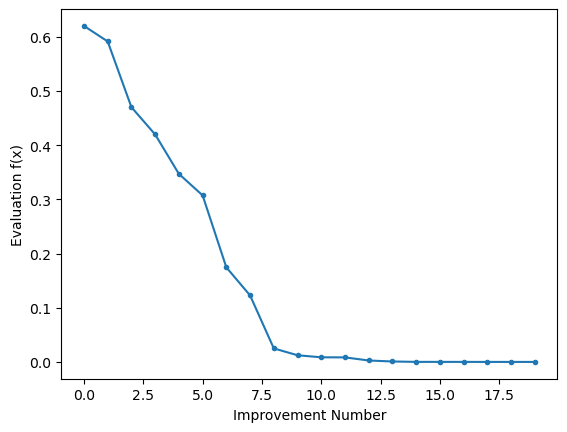

In [1]:
# simulated annealing search of a one-dimensional objective function
from numpy import asarray
from numpy import exp
from numpy.random import randn
from numpy.random import rand
from numpy.random import seed
from matplotlib import pyplot
 
# objective function
def objective(x):
    return x[0]**2.0
 
# simulated annealing algorithm
def simulated_annealing(objective, bounds, n_iterations, step_size, temp):
    # generate an initial point
    best = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
    # evaluate the initial point
    best_eval = objective(best)
    # current working solution
    curr, curr_eval = best, best_eval
    scores = list()
    # run the algorithm
    for i in range(n_iterations):
        # take a step
        candidate = curr + randn(len(bounds)) * step_size
        # evaluate candidate point
        candidate_eval = objective(candidate)
        # check for new best solution
        if candidate_eval < best_eval:
            # store new best point
            best, best_eval = candidate, candidate_eval
            # keep track of scores
            scores.append(best_eval)
            # report progress
            print('>%d f(%s) = %.5f' % (i, best, best_eval))
        # difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        # calculate temperature for current epoch
        t = temp / float(i + 1)
        # calculate metropolis acceptance criterion
        metropolis = exp(-diff / t)
        # check if we should keep the new point
        if diff < 0 or rand() < metropolis:
            # store the new current point
            curr, curr_eval = candidate, candidate_eval
    return [best, best_eval, scores]
 
# seed the pseudorandom number generator
seed(1)

# define range for input
bounds = asarray([[-5.0, 5.0]])

# define the total iterations
n_iterations = 1000

# define the maximum step size
step_size = 0.1

# initial temperature
temp = 10

# perform the simulated annealing search
best, score, scores = simulated_annealing(objective, bounds, n_iterations, step_size, temp)
print('Done!')
print('f(%s) = %f' % (best, score))

# line plot of best scores
pyplot.plot(scores, '.-')
pyplot.xlabel('Improvement Number')
pyplot.ylabel('Evaluation f(x)')
pyplot.show()

A line plot is created showing the objective function evaluation for each improvement during the search. We can see about 20 changes to the objective function evaluation during the search with large changes initially and very small to imperceptible changes towards the end of the search as the algorithm converged on the optima.

<div style="background-color: #e0f7fa; padding: 15px; border-radius: 5px;">

# Optional Task 1 : Hyperparameter Tuning Using Simulated Annealing for a Machine Learning Model

**Objective**: Implement the Simulated Annealing algorithm to optimize hyperparameters for a machine learning model (e.g., a Random Forest or Support Vector Machine). Use SA to find the best combination of hyperparameters that maximizes model accuracy on a given dataset.

## Problem Setup

- **Dataset**: Use a standard classification dataset, such as the **Iris**  dataset from `sklearn.datasets`. The dataset should be split into training and test sets.
  
- **Model**: Select a machine learning model, such as:
  - Random Forest Classifier
  - Support Vector Machine (SVM)
  - K-Nearest Neighbors (KNN)

### Hyperparameters

- **Random Forest**:
  - `n_estimators`: Number of trees
  - `max_depth`: Maximum depth of the trees
  - `min_samples_leaf`: Minimum samples per leaf
  
- **SVM**:
  - `C`: Regularization parameter
  - `kernel`: Kernel type (choices: `linear`, `poly`, `rbf`)
  
- **KNN**:
  - `n_neighbors`: Number of neighbors
  - `metric`: Distance metric (choices: `euclidean`, `manhattan`, `chebyshev`)

## Task Requirements

### Implement the Simulated Annealing Algorithm

1. **Initialize** a random combination of hyperparameters for the chosen model.
2. **Evaluate the model's performance** (e.g., accuracy) on the validation set.
3. **Perturb the current solution** by slightly modifying one of the hyperparameters to generate a new candidate solution.
4. **Calculate the acceptance probability** based on the difference in performance between the current and candidate solutions, and decide whether to accept the new solution.
5. **Iterate** the process, gradually decreasing the "temperature" parameter to reduce the acceptance of worse solutions over time.

### Hyperparameter Ranges

Define acceptable ranges for each hyperparameter:

- **Random Forest**:
  - `n_estimators`: 10 to 200
  - `max_depth`: 1 to 20
  - `min_samples_leaf`: 1 to 10
  
- **SVM**:
  - `C`: 0.1 to 10
  - `kernel`: One of [`linear`, `poly`, `rbf`]
  
- **KNN**:
  - `n_neighbors`: 1 to 30
  - `metric`: One of [`euclidean`, `manhattan`, `chebyshev`]

## Evaluation

- Track the best combination of hyperparameters and the corresponding accuracy on the validation set.
- Display the best hyperparameters and model accuracy achieved by the Simulated Annealing algorithm.
   
</div>

